In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from diffusers import DiffusionPipeline
import numpy as np
import random
import torch
from diffusers import StableDiffusionPipeline
import glob
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

from fid.fid_score import calculate_activation_statistics, save_statistics, load_statistics, calculate_frechet_distance, get_activations
from fid.inception import InceptionV3

from PIL import Image
from tqdm.auto import tqdm
from torch import autocast

from src.visualise import image_grid, latent_to_img, decode_latent, output_to_img
from schedulers.euler_discrete import EulerDiscreteCustomScheduler, FrozenDict, randn_tensor
from src.score_utils import get_sigmas, get_score_input, scale_input, get_score, step_score, denoise
from src.sampling_utils import random_step, langevin_step, repulsive_step
from src.kernel import RBF
from src.embedding import CNN, init_weights

import torch
import torch.nn as nn
import torch.nn.functional as F
# import autograd.numpy as anp

/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-03 19:16:21.539550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: module 'triton.language' has no attribute 'constexpr'


In [5]:
# Using 512x512 resolution
model_id = "stabilityai/stable-diffusion-2-base"
# model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)#, torch_dtype=torch.float16)
device = "cuda"
pipe = pipe.to(device)
pipe.safety_checker = None

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 7756.18it/s]
/data/ap2619/diffusion/score_sde_pytorch/.venv_score/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
# Settings
prompt = ["a black cat"]
config = {
    "pipe": pipe,
    "height": 512,
    "width": 512,
    "num_inference_steps": 20,
    "num_train_timesteps": 1000,
    "batch_size": 1,
    "cfg": 8,
    "beta_start": 0.00085,
    "beta_end": 0.012,
}

# Seeds
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(0)
random.seed(0)

# Noise levels
sigmas, timesteps = get_sigmas(config, device=device)
init_latents, text_embeddings = get_score_input(prompt, config, generator=generator, device="cuda")
config = {**config,
          "sigmas": sigmas,
          "timesteps": timesteps,
          "init_latents": init_latents,
          "text_embeddings": text_embeddings
          }

In [4]:
latent = denoise([1], 0, config, return_all_samples=False, generator=generator)

100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


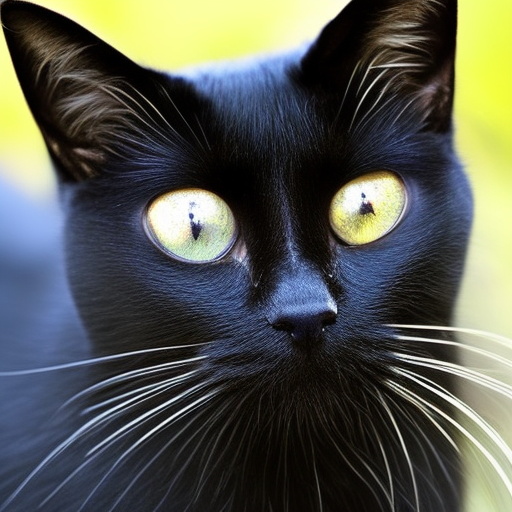

In [5]:
# Plot image results
image = output_to_img(decode_latent(latent, config['pipe'].vae))
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Particles

In [7]:
path = "model.pt"
net = CNN()
# Initialise weights
# net.apply(init_weights)
# Store weights and model
# torch.save(net.state_dict(), path)

# Load model instead of re-initialising
net.load_state_dict(torch.load(path))
net.to(torch.device("cuda"))

CNN(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (act): ReLU()
)

In [8]:
def repulsive_step(
        particles,
        scores,
        model,
        K,
        generator,
        add_noise = False,
        step_size=0.2,
        repulsive_scale=1000.0, # strength of repulsive term
        device="cuda",
    ):
        """ Take repulsive langevin step. 
            particles: list of latent samples
            score: list of scores for each latent sample
            model: embedding model for latents to smaller dim space
            K: Kernel function
        
        """
        phis = []
        grads = []
        for particle in particles:
            # Embed latent to smaller dimension
            phi = model(particle)
            phis.append(phi)

            # Compute gradient ∇_latent (phi) for pushforward gradient computation
            grad = torch.autograd.functional.jacobian(
                model, 
                particle.clone().detach().requires_grad_()
            )
            grads.append(grad)

        # Compute kernel gradients
        tphis = torch.stack(phis,axis=0)
        # Set bandwidth of RBF kernel with median heuristic
        K.bandwidth(tphis, tphis) 
        # Kernel grad shape: embedding_size x num_particles x num_particles
        kernel_grad = K.grad_first(tphis, tphis)
        kernel_grad_sum = torch.sum(kernel_grad, axis=-1)

        # Repulsive term
        n = len(particles)
        new_particles = []
        for i, phi in enumerate(phis):
            # Pushforward/Chain rule
            # TODO: Check this multiplication is right
            repulsive = torch.einsum('i,ijklm->jklm',kernel_grad_sum[:,i], grads[i]) / n

            # Langevin term
            noise = torch.randn(particles[i].shape, layout=particles[i].layout, device=device, generator=generator).to(device)

            # repulsive_norm = torch.norm(repulsive.reshape(repulsive.shape[0], -1), dim=-1).mean()
            # print(repulsive_norm.item())

            # Score + Repulsion
            new_particle = particles[i] + step_size * (scores[i] + repulsive_scale * repulsive)
            # ONLY Repulsion
            # new_particle = particles[i] + step_size * (repulsive_scale * repulsive)
            if add_noise:
                new_particle += ((step_size * 2) ** 0.5) * noise

            new_particles.append(new_particle)
        return new_particles

In [10]:
# Particle diffusion
def correct_particles(
    particles,
    sigma,
    t,
    correction_steps,
    correction_method,
    config,
    generator,
    step_size=0.2,
    model=None,
    K=None,
    ):
    """ At certain noise scale (step t), apply correction steps to all particles
        particles: N particles in the diffusion process
        method (str): type of correction step "random", "langevin", "score", or "repulsive"
        model: Embedding model (must be defined if repulsive correct_type specified)
        K: RBF Kernel (must be defined if repulsive correct_type specified)
        TODO: Make sampler factory class
    """
    if correction_method=="random":
        new_particles = random_step(particles, correction_steps, generator, step_size=step_size)
    elif correction_method=="repulsive":
        for _ in range(correction_steps):
            scores = [get_score(particle, sigma, t, config) for particle in particles]
            particles = repulsive_step(particles, scores, model, K, generator, step_size=step_size)
        new_particles = particles
    elif correction_method=="langevin" or correction_method=="score":
        new_particles = []
        add_noise = (correction_method=="langevin")
        for particle in particles:
            for _ in range(correction_steps):
                score = get_score(particle, sigma, t, config)
                particle = langevin_step(particle, score, generator, step_size=step_size, add_noise=add_noise)
            new_particles.append(particle)
    else:
        print(f"ERROR: Correction step type: '{correction_method}' not implemented yet")
            
    return new_particles

def denoise_particles(
    config,
    generator,
    correction_levels=[],
    correction_steps=1,
    correction_step_size=0.2,
    correction_method="langevin",
    addpart_level=0,
    addpart_steps=1,
    addpart_step_size=0.2,
    addpart_method="langevin",
    num_particles=1,
    Model=CNN,
    model_path=path,
    Kernel=RBF,
    device="cuda",
):
    """ General function to take steps and add particles at different noise levels of diffusion
        correction_levels (int or List[int]): noise level indices to do correction steps in
        correction_steps (int or List[int]): number of correction steps to take in each noise level
        correction_method (str or List[str]): method of correction e.g. random, langevin, score or repulsive 
        addpart_level (int): noise level index to add particles in
        addpart_steps (int): number of steps taken between particles
        addpart_method (str): method of steps for adding particles e.g. random, langevin, score or repulsive 
        config (Dict): info for diffusion
        generator: RNG generator - reset before calling this method
        num_particles=2: number of particles to add at addpart_level
        Model: Embedding model for repulsion
        model_path: path to embedding model weights
        Kernel=RBF: Kernel class to use for repulsive steps
        device="cuda",
    """
    # standard deviation of the initial noise distribution
    sigmas = config['sigmas']
    latents = config['init_latents'] * sigmas.max()

    # Embedding model for repulsive force
    model = Model()
    model.load_state_dict(torch.load(model_path))
    model.to(torch.device("cuda"))

    # Kernel
    K = Kernel()

    particles = [latents]
    for i, t in enumerate(tqdm(config['timesteps'])):
        t = t.to(device)
        step_index = (config['timesteps'] == t).nonzero().item()
        sigma = sigmas[step_index]

        # Create particles
        if i==addpart_level:
            for _ in range(num_particles-1):
                new_particle = correct_particles(
                    [particles[-1]], 
                    sigma, 
                    t, 
                    correction_steps=addpart_steps, 
                    correction_method=addpart_method, 
                    config=config, 
                    generator=generator, 
                    step_size=addpart_step_size, 
                    model=model, 
                    K=K
                )
                particles.append(new_particle[0])
        
        # Correction steps
        if i in correction_levels:
            particles = correct_particles(
                particles, 
                sigma, 
                t, 
                correction_steps, 
                correction_method=correction_method, 
                config=config, 
                generator=generator, 
                step_size=correction_step_size, 
                model=model, 
                K=K
            )
        
        # Move to next marginal in diffusion
        for n in range(len(particles)):
            score = get_score(particles[n], sigma, t, config)
            particles[n] = step_score(particles[n], score, sigmas, step_index)
    
    return particles

In [15]:
seed=1024
generator = torch.Generator("cuda").manual_seed(seed)
particles = denoise_particles(config, generator, num_particles=2, addpart_level=5, addpart_step_size=0.1, addpart_steps=100, addpart_method="score")

100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


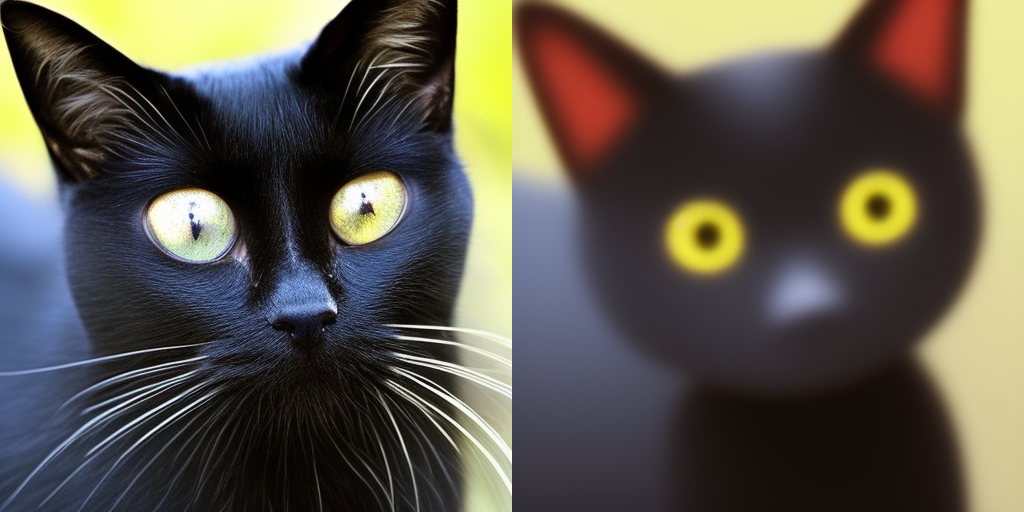

In [16]:
# Plot image results
# Plot list of decoded latents
visualise_latent_list = particles

pil_images = []
for l in visualise_latent_list:
    image = output_to_img(decode_latent(l, pipe.vae))
    images = (image * 255).round().astype("uint8")
    pil_images.append([Image.fromarray(image) for image in images][0])

image_grid(pil_images,1,len(visualise_latent_list))

Text(0.5, 0, 'Steps')

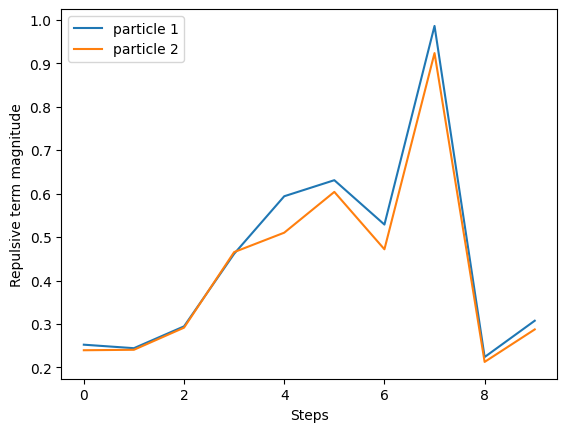

In [144]:
# Plot repulsive norms
with open('out.txt') as f:
    lines = f.readlines()
norms = [float(line.split()[0]) for line in lines]
plt.plot(norms[::2], label="particle 1")
plt.plot(norms[1::2], label="particle 2")
plt.legend()
plt.ylabel("Repulsive term magnitude")
plt.xlabel("Steps")